# ARIMA (p,d,q) model 

In [1]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

## Forecasting with ARIMA(p,d,q) 

In [3]:
df = pd.read_csv('data/qauselec.csv', index_col=0)
df.head()

,time,value
1,1956.00,3.923
2,1956.25,4.436
3,1956.50,4.806
4,1956.75,4.418
5,1957.00,4.339


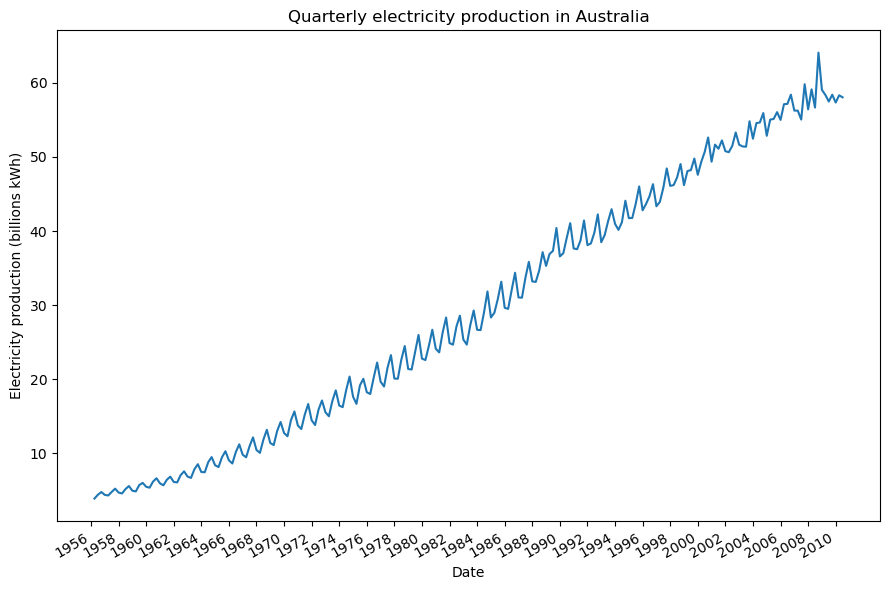

In [7]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.set_xlabel('Date')
ax.set_ylabel('Electricity production (billions kWh)')

plt.xticks(np.arange(0, 218, 8), np.arange(1956, 2012, 2))

plt.title('Quarterly electricity production in Australia')

fig.autofmt_xdate()
plt.tight_layout()

### General modling procedure 

#### Find value of *d* 

In [9]:
ad_fuller_result = adfuller(df['value'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.9963277229905643
p-value: 0.9942270502497619


In [10]:
df_diff = np.diff(df['value'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.1727118466027715
p-value: 0.021619564130374164


#### Train/test split 

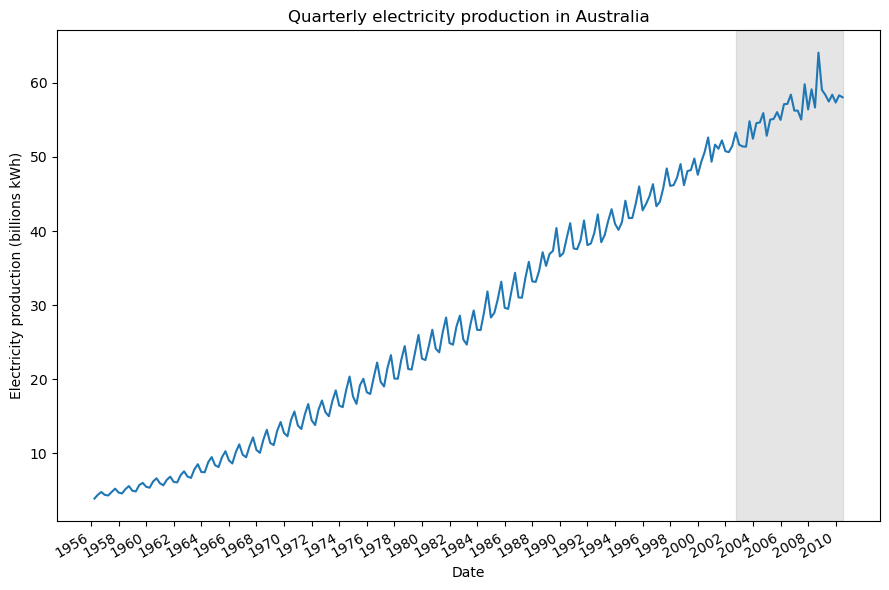

In [11]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.set_xlabel('Date')
ax.set_ylabel('Electricity production (billions kWh)')
ax.axvspan(187, 218, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 218, 8), np.arange(1956, 2012, 2))

plt.title('Quarterly electricity production in Australia')

fig.autofmt_xdate()
plt.tight_layout()

In [12]:
train = df['value'][:-32]
test = df.iloc[-32:]

In [13]:
def ARIMA_gridsearch(endog, min_p, max_p, min_q, max_q, d):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    
    all_orders = list(product(all_p, all_q))
    
    print(f'Fitting {len(all_orders)} unique models')
    
    results = []
    
    for order in tqdm_notebook(all_orders):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1])).fit()
        except:
            continue
            
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

#### Model selection with AIC 

In [14]:
result_df = ARIMA_gridsearch(train, 0, 4, 0, 4, 1)
result_df.head()

Fitting 25 unique models


  0%|          | 0/25 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(4, 4)",309.391220
1,"(4, 3)",327.287902
2,"(4, 2)",343.702173
3,"(4, 1)",348.707319
4,"(3, 4)",356.998400


In [15]:
model = SARIMAX(train, order=(4,1,4), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  186
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -145.696
Date:                Thu, 05 Jan 2023   AIC                            309.391
Time:                        14:34:30   BIC                            338.374
Sample:                             0   HQIC                           321.137
                                - 186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0157      0.023     -0.674      0.500      -0.061       0.030
ar.L2         -0.0204      0.023     -0.897      0.370      -0.065       0.024
ar.L3         -0.0198      0.024     -0.838      0.4

#### Residuals analysis 

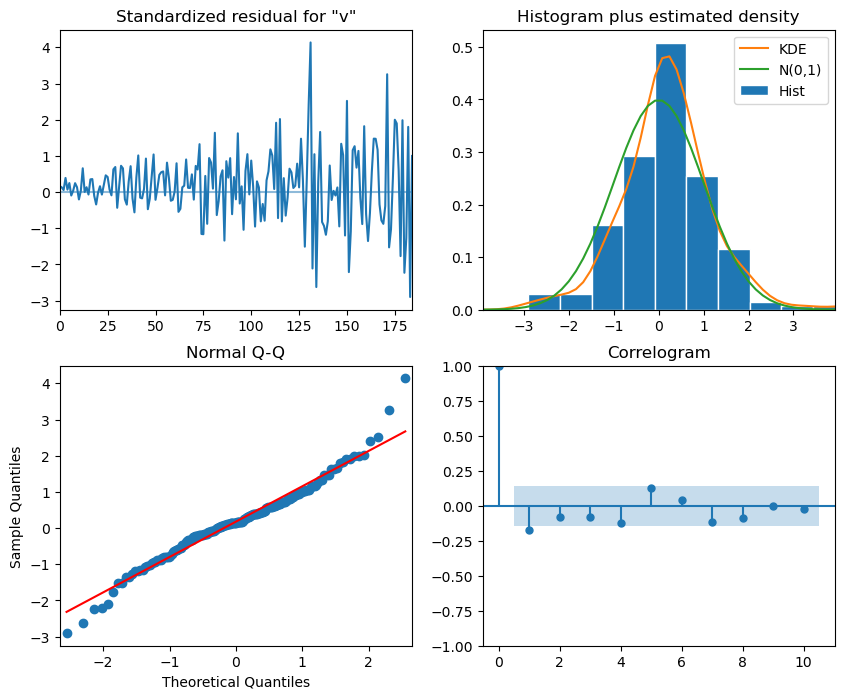

In [16]:
model_fit.plot_diagnostics(figsize=(10,8));

In [17]:
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('One p-value is smaller than 0.05')

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


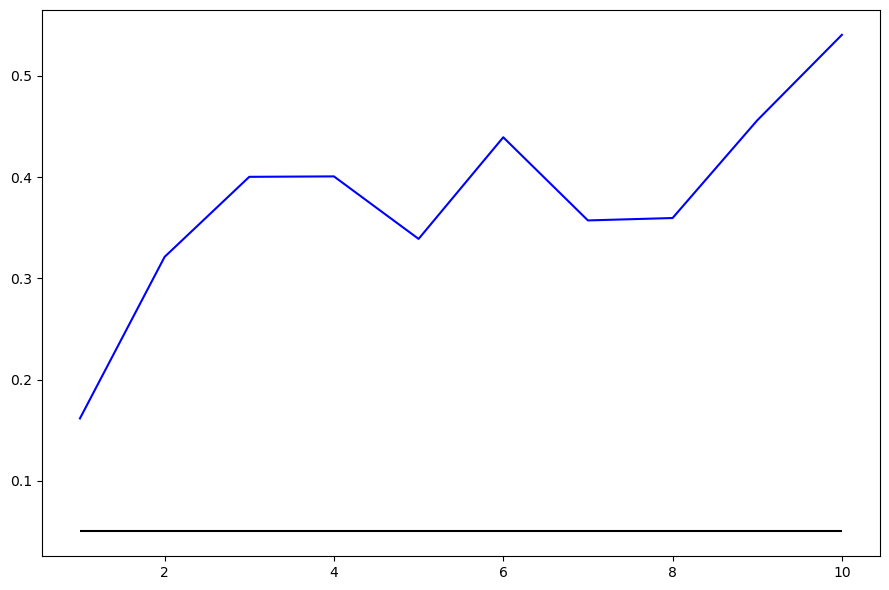

In [18]:
residuals = model_fit.resid

ljung_box_test(residuals, False, None)

#### Forecasting 

In [19]:
def rolling_predictions(df, train_len, horizon, window, period, method):
    
    TOTAL_LEN = train_len + horizon
    
    seasonal_steps = int((window/period))
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean[:horizon]

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_value = diff[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value[:horizon]
    
    elif method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_season = df[:i][-period:].values
            pred_last_season.extend(last_season for _ in range(seasonal_steps))

        pred_last_season = np.array(pred_last_season).reshape(1, -1)
        
        return pred_last_season[0][:horizon]
    
    if method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df[:i], order=(4,1,4))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA[:horizon]

In [20]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)

windows = [4, 8, 16, 32]

for window in windows:

    pred_mean = rolling_predictions(df['value'], TRAIN_LEN, HORIZON, window, 4, 'mean')
    pred_last_season = rolling_predictions(df['value'], TRAIN_LEN, HORIZON, window, 4, 'last_season')
    pred_ARIMA = rolling_predictions(df['value'], TRAIN_LEN, HORIZON, window, 4, 'ARIMA')

    pred_df[f'pred_mean_{window}'] = pred_mean
    pred_df[f'pred_last_season_{window}'] = pred_last_season
    pred_df[f'pred_ARIMA_{window}'] = pred_ARIMA

pred_df.head()

,time,value,pred_mean_4,pred_last_season_4,pred_ARIMA_4,pred_mean_8,pred_last_season_8,pred_ARIMA_8,pred_mean_16,pred_last_season_16,pred_ARIMA_16,pred_mean_32,pred_last_season_32,pred_ARIMA_32
187,2002.50,53.299,24.806237,52.226,53.113270,24.806237,52.226,53.113270,24.806237,52.226,53.113270,24.806237,52.226,53.113270
188,2002.75,51.646,24.806237,50.778,50.871787,24.806237,50.778,50.871787,24.806237,50.778,50.871787,24.806237,50.778,50.871787
189,2003.00,51.415,24.806237,50.639,51.725124,24.806237,50.639,51.725124,24.806237,50.639,51.725124,24.806237,50.639,51.725124
190,2003.25,51.379,24.806237,51.486,52.227636,24.806237,51.486,52.227636,24.806237,51.486,52.227636,24.806237,51.486,52.227636
191,2003.50,54.808,25.377363,53.299,53.305332,24.806237,52.226,53.837656,24.806237,52.226,53.837656,24.806237,52.226,53.837656


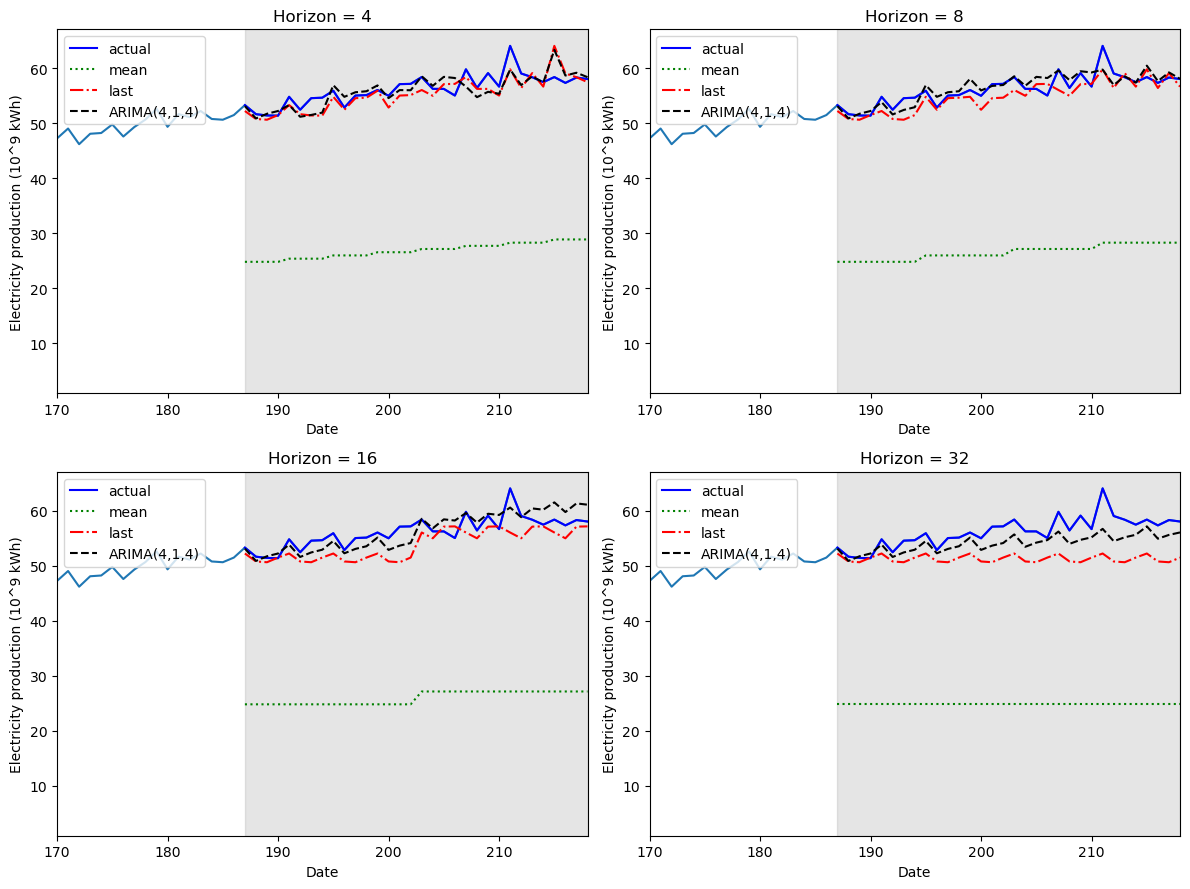

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['value'])
    ax.plot(pred_df['value'], 'b-', label='actual')
    ax.plot(pred_df[f'pred_mean_{windows[i]}'], 'g:', label='mean')
    ax.plot(pred_df[f'pred_last_season_{windows[i]}'], 'r-.', label='last')
    ax.plot(pred_df[f'pred_ARIMA_{windows[i]}'], 'k--', label='ARIMA(4,1,4)')
    
    ax.legend(loc=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Electricity production (10^9 kWh)')
    ax.axvspan(187, 218, color='#808080', alpha=0.2)
    ax.set_xlim(170, 218)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.tight_layout()

#### Evaluation 

In [22]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [23]:
mape_naive_seasonal_4 = mape(pred_df['value'], pred_df['pred_last_season_4'])
mape_ARIMA_4 = mape(pred_df['value'], pred_df['pred_ARIMA_4'])

mape_naive_seasonal_8 = mape(pred_df['value'], pred_df['pred_last_season_8'])
mape_ARIMA_8 = mape(pred_df['value'], pred_df['pred_ARIMA_8'])

mape_naive_seasonal_16 = mape(pred_df['value'], pred_df['pred_last_season_16'])
mape_ARIMA_16 = mape(pred_df['value'], pred_df['pred_ARIMA_16'])

mape_naive_seasonal_32 = mape(pred_df['value'], pred_df['pred_last_season_32'])
mape_ARIMA_32 = mape(pred_df['value'], pred_df['pred_ARIMA_32'])

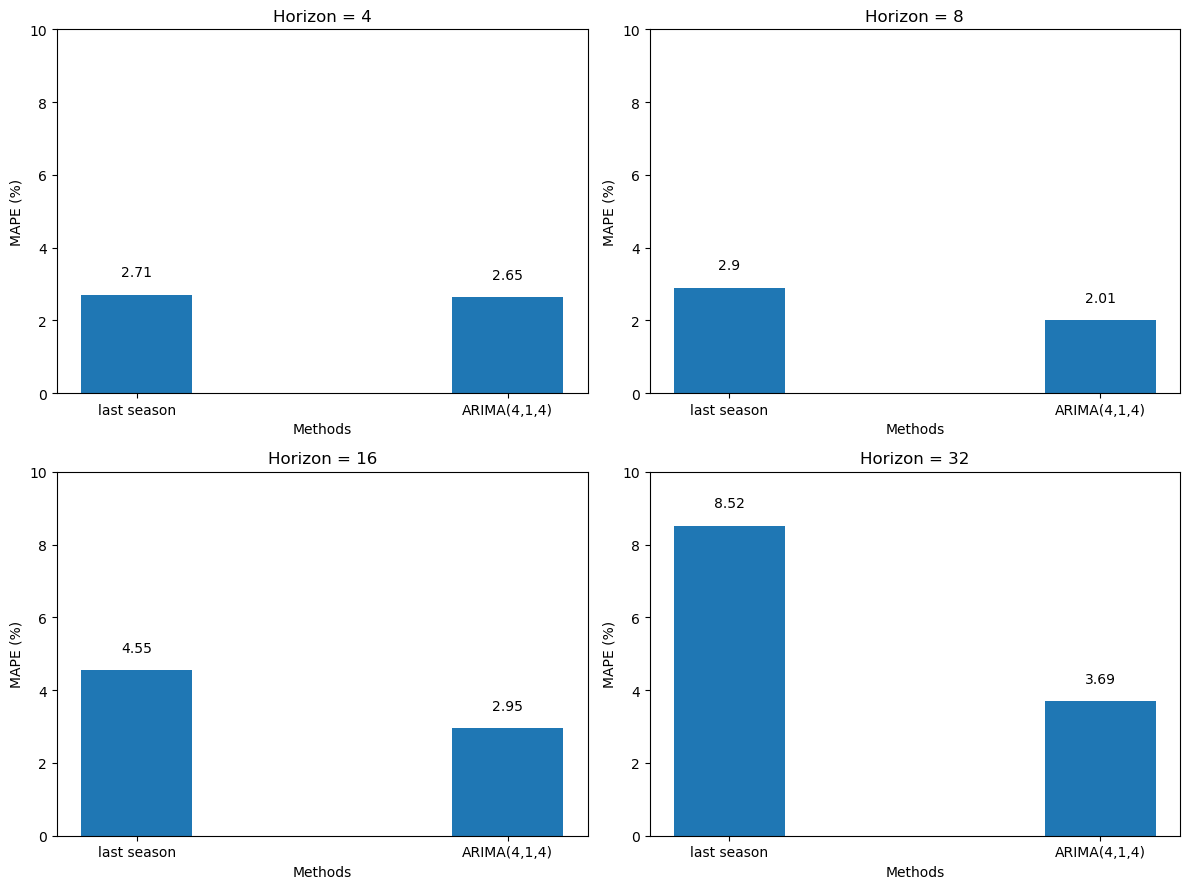

In [26]:
mapes_naive_seasonal = [mape_naive_seasonal_4, mape_naive_seasonal_8, mape_naive_seasonal_16, mape_naive_seasonal_32]
mapes_ARIMA = [mape_ARIMA_4, mape_ARIMA_8, mape_ARIMA_16, mape_ARIMA_32]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

x = ['last season', 'ARIMA(4,1,4)']
width = 0.3

for i, ax in enumerate(axes.flatten()):
    
    y = [mapes_naive_seasonal[i], mapes_ARIMA[i]]
    ax.bar(x, y, width)
    ax.set_xlabel('Methods')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, 10)
    ax.set_title(f'Horizon = {windows[i]}')    
    
    for index, value in enumerate(y):
        ax.text(x=index, y=value+0.5, s=str(value), ha='center')

plt.tight_layout()